In [ ]:
import random
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import load_dataset
import matplotlib.pyplot as plt
from collections import defaultdict


In [ ]:

# ---------------------------
# 재현성용 시드 설정 함수
# ---------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    # cuDNN 비결정성 제어 (재현성 확보)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:

# ---------------------------
# 모델 정의 (활성화 주입 가능)
# ---------------------------
class MLP(nn.Module):
    def __init__(self, activation_fn, input_size=784, hidden_size=200, num_classes=10):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            activation_fn,
            nn.Linear(hidden_size, num_classes)
        )
    def forward(self, x):
        return self.net(x)

In [ ]:

# ---------------------------
# 데이터 준비
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mnist = load_dataset("mnist")
sample_data = torch.stack([transforms.ToTensor()(mnist['train'][i]['image']) for i in range(1000)])
mean, std = sample_data.mean().item(), sample_data.std().item()
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean,), (std,))])

def transform_dataset(dataset):
    def transform_fn(batch):
        images = [transform(img).view(-1) for img in batch["image"]]
        return {"image": torch.stack(images), "label": torch.tensor(batch["label"])}
    return dataset.with_transform(transform_fn)

train_dataset = transform_dataset(mnist["train"])
test_dataset = transform_dataset(mnist["test"])

# DataLoader에서 재현성 보장을 위해 generator와 worker_init_fn 사용 (멀티워커 환경 안전)
def seed_worker(worker_id):
    worker_seed = 42 + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(42)

def get_loaders(batch_size=128):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              worker_init_fn=seed_worker, generator=g)
    test_loader  = DataLoader(test_dataset,  batch_size=1000, shuffle=False)
    return train_loader, test_loader


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

mnist/train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

mnist/test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:

# ---------------------------
# 학습/평가 함수 (시간 측정 포함)
# ---------------------------
def train_and_eval_with_activation(activation, seed=42,
                                   hidden_size=200, lr=1e-3, epochs=3, batch_size=128):
    set_seed(seed)  # 재현성 확보
    train_loader, test_loader = get_loaders(batch_size)
    act_layer = activation  # nn.Module instance (예: nn.ReLU())
    model = MLP(act_layer, hidden_size=hidden_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    start_time = time.time()
    train_losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch in train_loader:
            imgs = batch["image"].to(device)
            labels = batch["label"].to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))
    train_time = time.time() - start_time

    # 평가
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in test_loader:
            imgs = batch["image"].to(device)
            labels = batch["label"].to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    test_acc = 100 * correct / total
    return test_acc, train_time, train_losses


In [ ]:

# ---------------------------
# 활성화 함수 목록 및 실험 루프
# ---------------------------
activations = {
    "ReLU": nn.ReLU(),
    "LeakyReLU": nn.LeakyReLU(0.01),
    "Tanh": nn.Tanh(),
    "ELU": nn.ELU(),
    "SELU": nn.SELU()
}

results = {}
hidden_size = 200
lr = 1e-3
epochs = 5
batch_size = 128
seed = 42  # 고정

for name, act in activations.items():
    print(f"\n=== Activation: {name} ===")
    acc, t, losses = train_and_eval_with_activation(act, seed=seed,
                                                   hidden_size=hidden_size,
                                                   lr=lr, epochs=epochs, batch_size=batch_size)
    results[name] = {"acc": acc, "time": t, "losses": losses}
    print(f"Test Acc: {acc:.2f}%, Train Time: {t:.2f}s")



=== Activation: ReLU ===
Test Acc: 97.48%, Train Time: 87.20s

=== Activation: LeakyReLU ===
Test Acc: 97.98%, Train Time: 84.12s

=== Activation: Tanh ===
Test Acc: 97.77%, Train Time: 83.81s

=== Activation: ELU ===
Test Acc: 98.03%, Train Time: 84.09s

=== Activation: SELU ===
Test Acc: 97.77%, Train Time: 83.32s


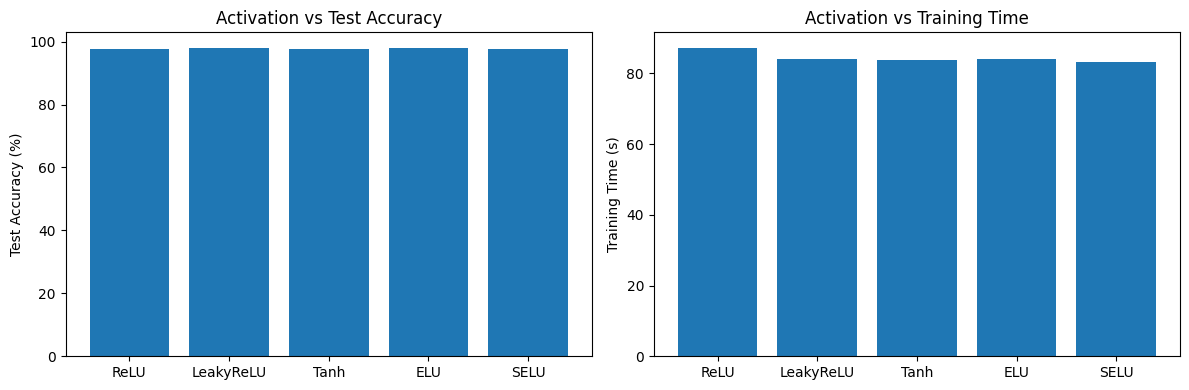

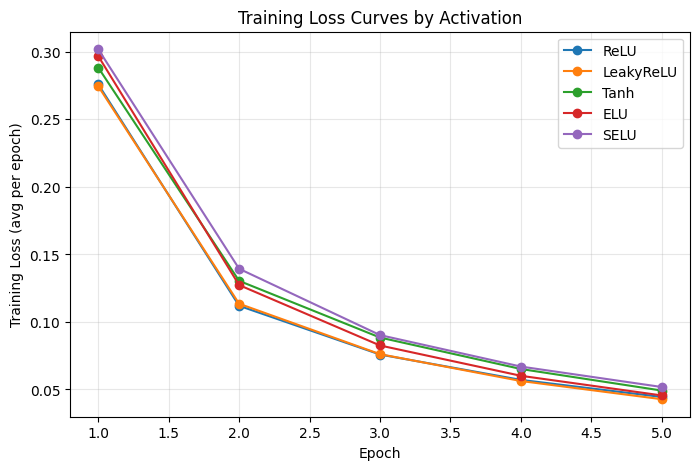

In [ ]:

# ---------------------------
# 시각화: 정확도와 훈련 손실 곡선
# ---------------------------
# 정확도 바 차트
names = list(results.keys())
accs = [results[n]["acc"] for n in names]
times = [results[n]["time"] for n in names]

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.bar(names, accs)
plt.ylabel("Test Accuracy (%)")
plt.title("Activation vs Test Accuracy")

plt.subplot(1,2,2)
plt.bar(names, times)
plt.ylabel("Training Time (s)")
plt.title("Activation vs Training Time")
plt.tight_layout()
plt.show()

# 훈련 손실 곡선 (모든 활성화 함수의 epoch별 loss)
plt.figure(figsize=(8,5))
for name in names:
    plt.plot(range(1, epochs+1), results[name]["losses"], marker='o', label=name)
plt.xlabel("Epoch")
plt.ylabel("Training Loss (avg per epoch)")
plt.title("Training Loss Curves by Activation")
plt.legend()
plt.grid(alpha=0.3)
plt.show()